In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("1-col"),
    ]
)

In [59]:
NAN = np.nan
data_blocks = [
    # outer dimension is victim visits (4, 16, 256, 4096)
    # rows are h0....h9,b18,vit
    # columns are r0...r9,attack-h9,cont-adv,ko-adv,attack-vit
    # value is victim win rate (row's win rate against column)
    # NAN = no data
    [
        [  1.0,    1.0,    0.0,    1.0,    1.0,    2.0,    2.0,    1.0,    0.0,    0.0,    1.4,    0.0,   97.0,    0.5],
        [  6.0,    0.0,    0.0,    4.0,    0.0,    1.0,    0.0,   15.0,    4.0,    8.0,    9.7,    9.0,    NAN,    NAN],
        [ 13.0,    3.0,    0.0,    2.0,    1.0,    1.0,    3.0,    3.0,    2.0,    7.0,    5.5,    0.0,    NAN,    NAN],
        [ 15.0,    9.0,    3.0,    1.0,    1.0,    3.0,    0.0,    4.0,    6.0,   11.0,    4.8,   17.0,    NAN,    NAN],
        [ 12.0,   18.0,   30.0,    9.0,    0.0,    5.0,    3.0,    1.0,    0.0,    6.0,    4.8,   16.0,    NAN,    NAN],
        [  1.0,   12.0,    3.0,    2.0,    9.0,    3.0,    3.0,    4.0,    1.0,    5.0,    4.7,   14.0,    NAN,    NAN],
        [  9.0,   12.0,    2.0,    1.0,    3.0,    3.0,    1.0,    3.0,    0.0,    7.0,    2.7,   12.0,    NAN,    NAN],
        [  4.0,    9.0,    0.0,    0.0,   12.0,    9.0,    5.0,    4.0,    2.0,    7.0,    9.6,   10.0,    NAN,    NAN],
        [  6.0,   20.0,    3.0,    1.0,   10.0,   10.0,   14.0,   13.0,    3.0,    8.0,    6.2,   14.0,    NAN,    NAN],
        [ 11.0,   14.0,    1.0,    1.0,    2.0,   10.0,   14.0,   25.0,   12.0,   14.0,    4.5,   16.0,  100.0,   14.0],
        [100.0,   96.0,   24.0,   70.0,   15.0,   76.0,   66.0,   37.0,   19.0,    9.0,   31.0,    0.0,    2.0,   93.5],
        [ 45.4,   24.0,    6.0,    5.0,    3.0,    4.0,    1.0,    6.0,    0.0,    1.0,   79.0,    5.0,  100.0,    1.5],
    ],
    [
        [  0.0,    2.0,    2.0,    6.0,    4.0,    7.0,    2.0,    3.0,    1.0,    0.0,    2.0,    1.0,  100.0,    1.5],
        [ 87.0,    1.0,    2.0,    2.0,    1.0,    3.0,    1.0,    6.0,    8.0,    9.1,   11.0,   12.0,    NAN,    NAN],
        [ 94.0,   66.0,    1.0,    5.0,   10.0,   21.0,   14.0,    6.0,    3.0,    9.8,    7.0,    9.0,    NAN,    NAN],
        [ 88.0,   85.0,   87.0,   11.0,    9.0,   27.0,   32.0,    4.0,   10.0,    1.8,    5.0,   25.0,    NAN,    NAN],
        [ 87.0,   90.0,   84.0,   82.0,    6.0,   75.0,   74.0,    6.0,   13.0,   13.6,    1.0,   41.0,    NAN,    NAN],
        [ 72.0,   91.0,   85.0,   92.0,   91.0,   46.0,   45.0,    2.0,    5.0,    8.9,    8.0,   24.0,    NAN,    NAN],
        [ 81.0,   83.0,   83.0,   92.0,   92.0,   90.0,   59.0,    1.0,    7.0,    5.4,    4.0,   38.0,    NAN,    NAN],
        [ 84.0,   84.0,   82.0,   94.0,   91.0,   86.0,   74.0,   11.0,   14.0,   10.7,   38.0,   40.0,    NAN,    NAN],
        [ 93.0,   89.0,   87.0,   83.0,   93.0,   92.0,   86.0,   84.0,   78.0,   43.6,    8.0,   37.0,    NAN,    NAN],
        [ 81.0,   91.0,   77.0,   94.0,   84.0,   92.0,   80.0,   95.0,   94.0,   21.0,    2.5,   40.0,  100.0,   56.0],
        [ 99.0,  100.0,   67.0,   98.0,   65.0,   96.0,   94.0,   55.0,   54.0,   44.0,   86.0,    1.0,    0.0,   93.0],
        [ 76.6,   49.0,   16.0,   27.0,   24.0,   19.0,   21.0,   22.0,    6.0,    4.0,  100.0,   37.0,  100.0,    1.0],
    ],
    [
        [  1.0,    2.0,    3.0,   23.0,    9.0,    9.0,   13.0,    4.0,    3.0,    5.0,   12.9,    7.0,  100.0,    3.0],
        [100.0,   14.0,    6.0,   12.0,    6.0,   26.0,   19.0,   31.0,   32.0,   39.0,   32.9,   65.0,    NAN,    NAN],
        [100.0,   96.0,    5.0,   31.0,   35.0,   69.0,   58.0,   44.0,   46.0,   59.0,   35.7,   86.0,    NAN,    NAN],
        [ 99.0,   99.0,   96.0,   33.0,   40.0,   80.0,   82.0,   35.0,   40.0,   57.0,   27.1,   97.0,    NAN,    NAN],
        [ 99.0,   97.0,   94.0,  100.0,   46.0,   98.0,   93.0,   45.0,   62.0,   54.0,   20.7,   99.0,    NAN,    NAN],
        [100.0,  100.0,   98.0,  100.0,  100.0,   97.0,   96.0,   38.0,   59.0,   64.0,   21.8,  100.0,    NAN,    NAN],
        [ 99.0,   97.0,   98.0,  100.0,   98.0,   99.0,   91.0,   39.0,   45.0,   47.0,   39.7,   99.0,    NAN,    NAN],
        [100.0,   98.0,   92.0,  100.0,   98.0,  100.0,   99.0,   53.0,   55.0,   56.0,   66.7,   98.0,    NAN,    NAN],
        [ 98.0,   97.0,   98.0,  100.0,  100.0,  100.0,   99.0,  100.0,  100.0,   95.0,   44.4,  100.0,    NAN,    NAN],
        [ 99.0,   98.0,   92.0,  100.0,   99.0,  100.0,   96.0,   98.0,   98.0,   65.0,    6.9,   95.0,  100.0,   97.0],
        [100.0,  100.0,   97.0,  100.0,  100.0,  100.0,  100.0,   98.0,   99.0,   95.0,   96.0,    7.6,   12.0,   99.5],
        [ 99.0,   87.0,   18.0,   88.0,   64.0,   80.0,   79.0,   99.0,   92.0,   86.0,  100.0,   97.0,  100.0,    4.0],
    ],
    [
        [  1.0,    5.0,    4.0,   24.0,    6.0,   14.0,   15.0,   13.0,    9.0,    9.0,   70.0,    NAN,    NAN,    NAN],
        [ 99.0,   31.0,   10.0,   34.0,   25.0,   55.0,   50.0,   59.0,   61.0,   79.0,   95.9,    NAN,    NAN,    NAN],
        [100.0,  100.0,   44.0,   71.0,   88.0,   95.0,   90.0,   78.0,   79.0,   93.0,   97.1,    NAN,    NAN,    NAN],
        [100.0,   99.0,  100.0,   67.0,   78.0,   95.0,   92.0,   77.0,   74.0,   91.0,   98.0,    NAN,    NAN,    NAN],
        [100.0,  100.0,   98.0,  100.0,   75.0,   99.0,   98.0,   86.0,   91.0,   98.0,   98.0,    NAN,    NAN,    NAN],
        [100.0,  100.0,  100.0,  100.0,  100.0,  100.0,  100.0,   73.0,   84.0,   91.0,   99.0,    NAN,    NAN,    NAN],
        [ 99.0,  100.0,   97.0,  100.0,  100.0,  100.0,   98.0,   70.0,   76.0,   83.0,   99.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   98.0,  100.0,   99.0,  100.0,  100.0,   68.0,   70.0,   90.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   99.0,  100.0,  100.0,  100.0,   99.0,  100.0,  100.0,   99.0,  100.0,    NAN,    NAN,    NAN],
        [100.0,   99.0,   94.0,  100.0,   99.0,  100.0,   99.0,  100.0,  100.0,   94.0,   96.0,    NAN,    NAN,    NAN],
        [  NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,   NAN,     NAN,   35.2,   94.0,    NAN],
        [  NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    NAN,    7.6],
    ],
]

/tmp/ipykernel_349921/4140674730.py:47: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/ipykernel_349921/4140674730.py:47: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


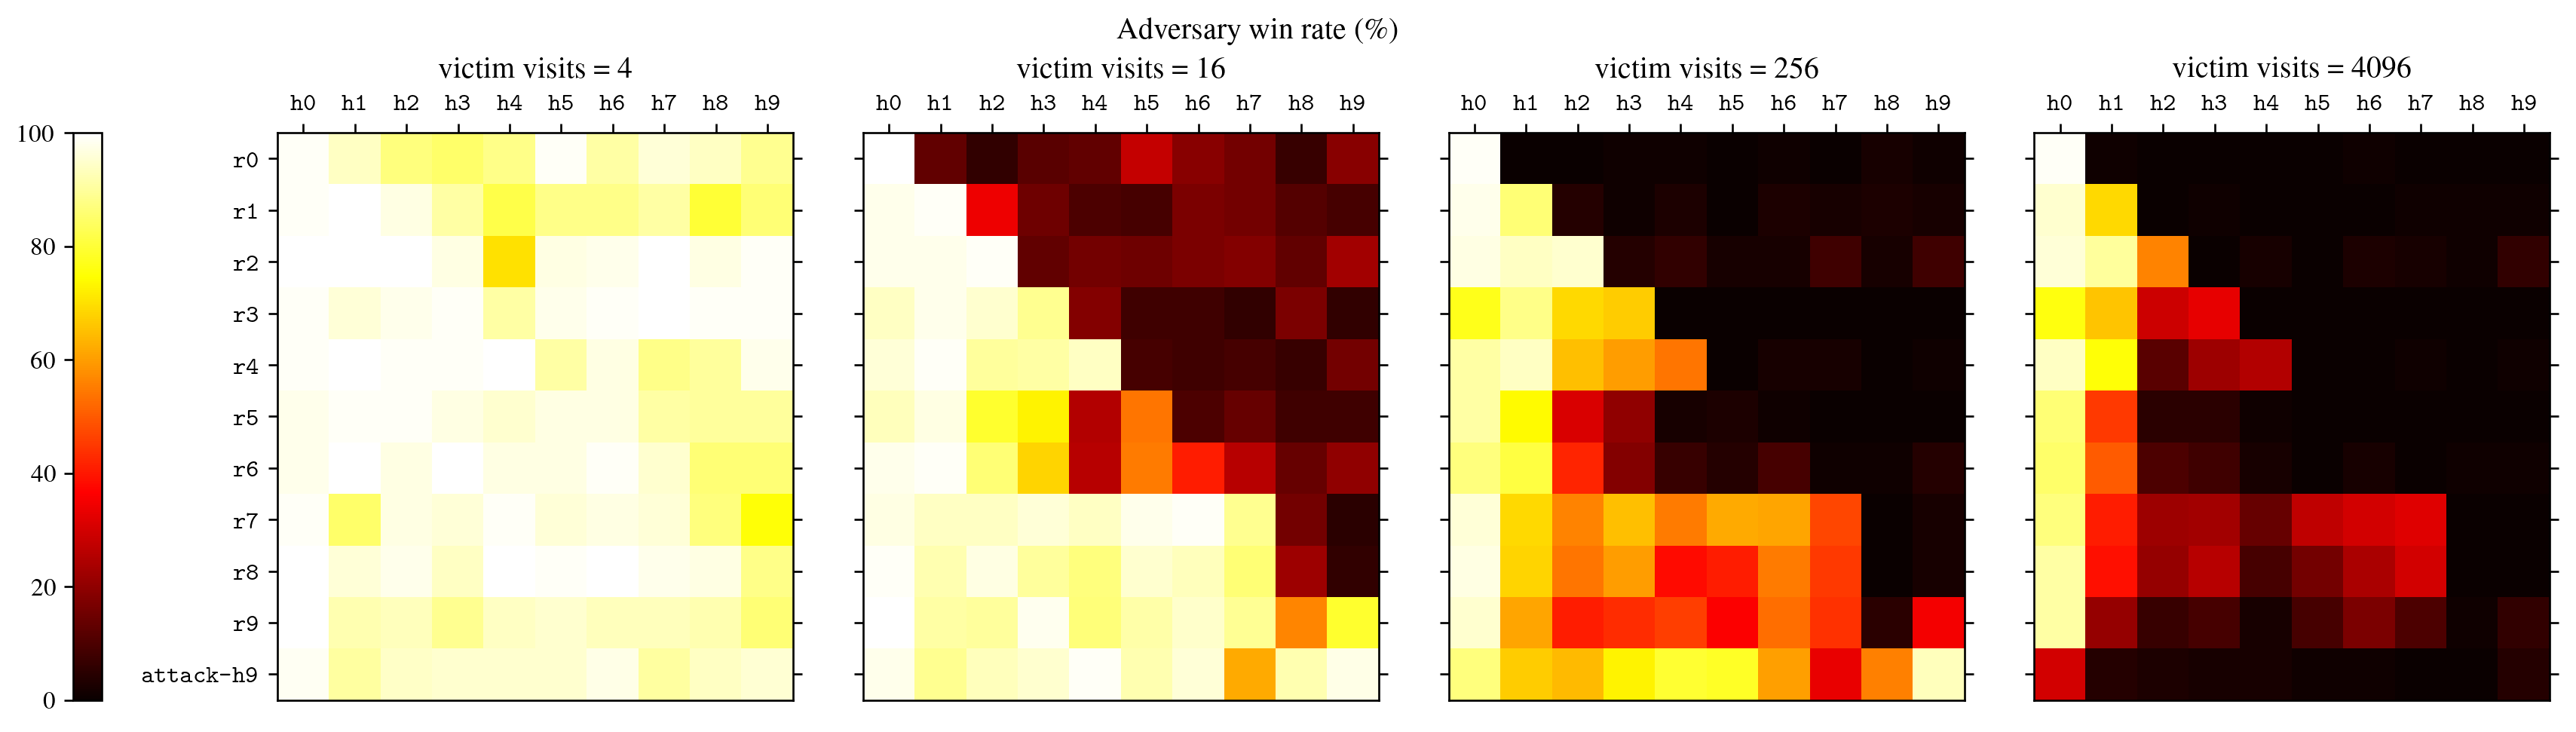

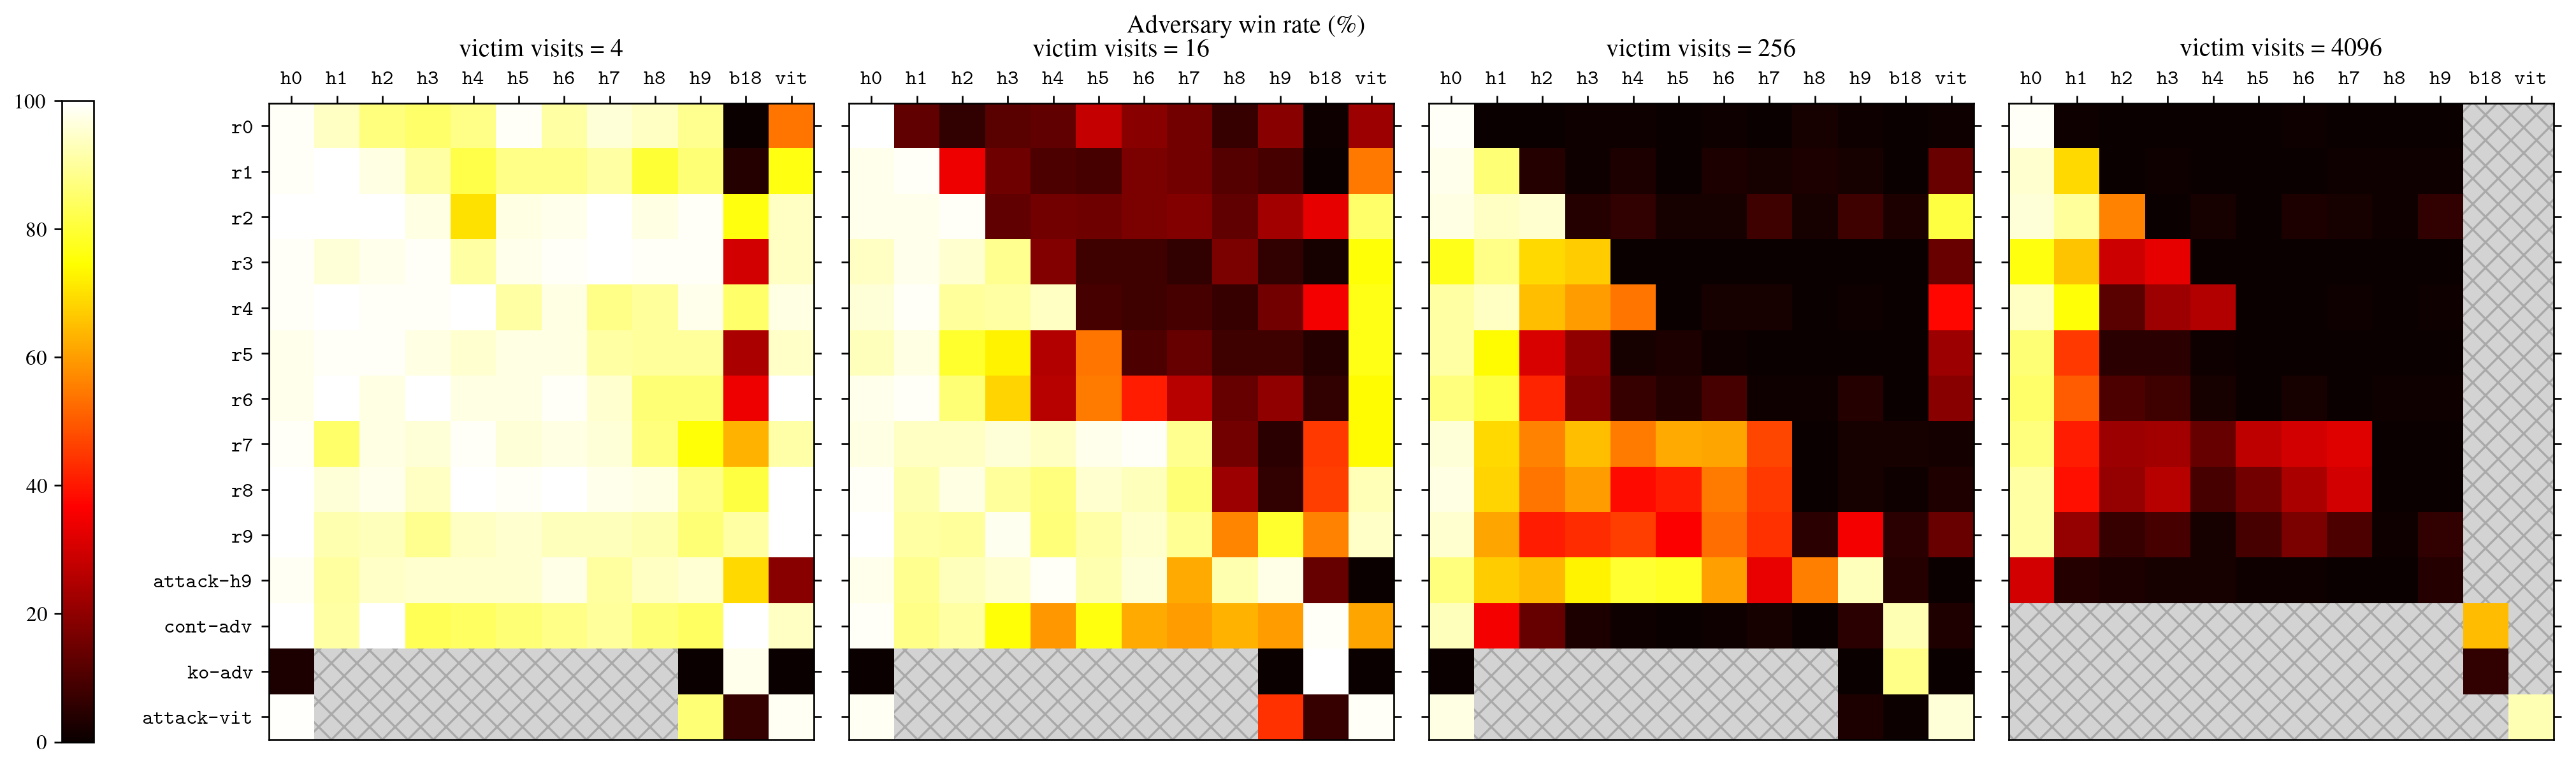

In [62]:
x_labels = ["h0", "h1", "h2", "h3", "h4", "h5", "h6", "h7", "h8", "h9", "b18", "vit"]
y_labels = ["r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9", "attack-h9", "cont-adv", "ko-adv", "attack-vit"]
victim_visits = ["4", "16", "256", "4096"]

for label, x_range, y_range, x_figsize, y_figsize in [
    # Create one version of the plot with only iterated adv training
    # and another with all results, because it's not clear we want to present
    # all results at once in the body of the paper
    ("iteradvtrain", x_labels.index("h9") + 1, y_labels.index("attack-h9") + 1, 15, 4),
    ("full", len(x_labels), len(y_labels), 17.5, 5) 
]:
    fig, axs = plt.subplots(1, 4, figsize=(x_figsize, y_figsize), sharey=True)
    fig.suptitle("Adversary win rate (\%)")
    
    vmin = 0
    vmax = 100
    color_map = matplotlib.colormaps.get_cmap("hot")
    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    for i, block in enumerate(data_blocks):
        data = np.array(block)
    
        # We usually report adversary win rates in our paper, so let's invert the
        # victim-win-rate data.
        # Also, let's put the adversaries as rows instead.
        data = 100 - data.T
        data = data[:y_range, :x_range]
    
        axs[i].imshow(data, cmap=color_map, norm=normalizer)
    
        axs[i].set_xticks(np.arange(len(x_labels[:x_range])))
        axs[i].set_yticks(np.arange(len(y_labels[:y_range])))
        axs[i].set_xticklabels(rf"\texttt{{{name}}}" for name in x_labels[:x_range])
        axs[i].set_yticklabels(rf"\texttt{{{name}}}" for name in y_labels[:y_range])
    
        # fig.colorbar(im, ax=axs[i])
    
        axs[i].set_title(f"victim visits = {victim_visits[i]}")
    
        # Set the appearance of NaN cells
        axs[i].patch.set(hatch="xx", facecolor="lightgray", edgecolor="darkgray")

        # Move x-axis labels to top so that r0 and h0 are together at the top-left
        # corner
        axs[i].xaxis.tick_top()
    
    color_bar_info = matplotlib.cm.ScalarMappable(cmap=color_map, norm=normalizer)
    fig.tight_layout()
    # colorbar apparently doesn't play nice with tight_layout, so we add it
    # afterwards
    fig.colorbar(color_bar_info, ax=axs, location="left", pad=0.07, fraction=0.015)
    
    
    fig.savefig(f"win-rate-{label}-heatmap.pgf", backend="pgf")